# SECTION 19: MULTIPLE LINEAR REGRESSION

- online-ds-ft-070620
- 08/20/20

## Announcements

- **Questions re: YouTube Playlist Video Changes to reduce delay**
    - No title screens (just started)
    - 720p Video (have been doing for a while. Has anyone had issues when watching study groups?)
    

    

## Resources:

- **[OSEMN Data Science Workflow Notebook](https://github.com/jirvingphd/fsds-osemn-workflow)**
    - `student_OSEMN.ipynb`: also included in notes repo

## LEARNING OBJECTIVES

- Learn how to expand our last lesson to include multiple independent variables.
- Learn ways to deal with categorical variables.
- Learn about multicollinearity of features
- Learn about how to improve a baseline model based on results
- Learn how to run a multiple regression using statsmodels

<!-- ### TOPICS:

#### Part 1 
- Multiple Linear Regression
- Dealing with Categorical Variables
- Multicollinearity of Features
- Multiple Linear Regression in Statsmodels

#### Part 2
- Feature Scaling & Normalization
- Model Fit and Validation/Cross Validation -->

## Questions?



- Introduction to Cross-Validation - Lab - Cross-Validation using Scikit-Learn solution

- Multiple Linear Regression in Statsmodels - Lab 
    - is there a way to easily create the regression equation when there are so many coefficients?


- Can we possibly work through a full practical linear regression workflow from start to finish? 
    - Stats testing the data for assumptions, splitting, training, testing, validation, and inference or prediction results to get a fuller understanding of the realistic linear regression workflow as it pertains to the job.


# PREVIOUSLY ON...

## Single Linear Regression

- We discussed how the mean is our worst model.

- We discussed the assumptions for a linear regression:
    - Linear relationship between predictor and target variable.
    - Predictor (x) and its error terms have a normal distribution
    - Homoskedasticity ( variance of residuals is constant)
    
- We learned how to run a single regession in statsmodels

In [1]:
!pip install -U fsds
from fsds.imports import *

fsds v0.2.23 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10,6]

In [3]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats

import warnings
# warnings.filterwarnings('ignore')

In [4]:
## Load in ames dataset
df = fs.datasets.load_ames_train(subset=True)

## Preview Data
# display(df.head());

## Save Columns of Interest
X = df['GrLivArea'].copy()
y = df['SalePrice'].copy()

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'GrLivArea vs SalePrice'}, xlabel='GrLivArea', ylabel='SalePrice'>)

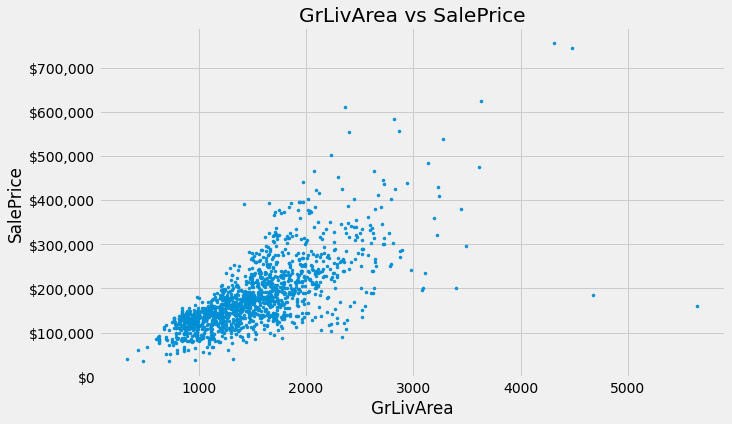

In [5]:

## Formatting 
priceFmt = mpl.ticker.StrMethodFormatter("${x:,.0f}")

## Scatter Plots for Linearity Check
def plot_data(X,y,xlabel='GrLivArea',ylabel='SalePrice'):
    
    fig, ax = plt.subplots()
    
    ax.scatter(X,y,marker='.')
    
    ax.set(xlabel=xlabel,ylabel=ylabel)
    ax.set_title(f'{xlabel} vs {ylabel}')
    
    ax.yaxis.set_major_formatter(priceFmt)
    return fig,ax

plot_data(X,y)

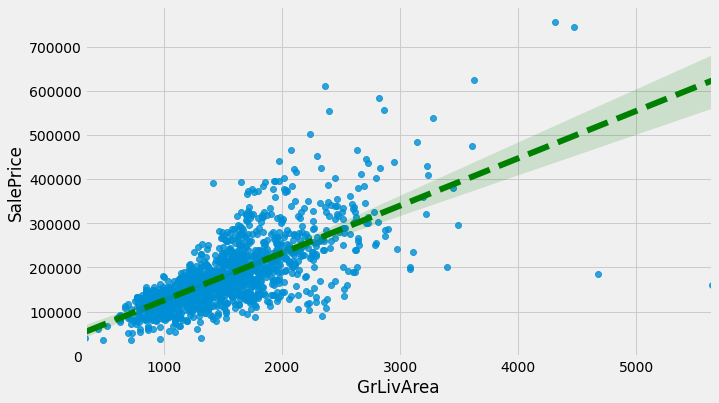

In [6]:
## Check Linearity 
ax = sns.regplot(X,y,line_kws={'color':'green','ls':'--'})

In [7]:
np.quantile(y,.75)

214000.0

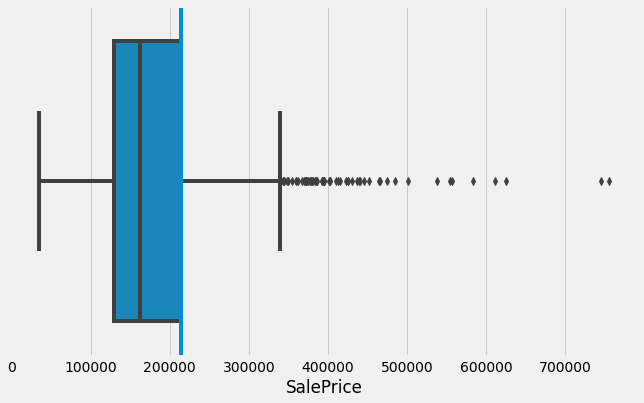

In [8]:
ax = sns.boxplot(y);
q3 = np.quantile(y,.75)
q1 = np.quantile(y,.25)
IQR = q3 - q1
ax.axvline(q3)
upper_threshold = q3 + 1.5*IQR
lower_threshold = q1 - 1.5*IQR

# ax.axline(upper_threshold)


In [9]:
## Check for outliers
from scipy import stats
def find_outliers_z(data):
    zFP = np.abs(stats.zscore(data))
    zFP = pd.Series(zFP, index=data.index)
    idx_outliers = zFP > 3
    return idx_outliers

In [10]:
## Get X outliers
X_outliers = find_outliers_z(X)
X_outliers.sum()

16

In [11]:
## Get y outliers
y_outliers = find_outliers_z(y)
y_outliers.sum()

22

In [12]:
# ## Make a DataFrame of Outliers
# df_outliers = pd.DataFrame({'X':X_outliers,
#                            'y':y_outliers})
# df_outliers['any'] = df_outliers.any(axis=1)
# ## Add column of any outliers
# df_outliers['any'].value_counts()

# idx_outliers = df_outliers['any'].copy()
# ~idx_outliers

In [13]:
len(X)

1460

In [14]:
idx_outliers = np.any(np.stack([X_outliers,y_outliers],axis=1), axis=1)
idx_outliers.shape

(1460,)

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'GrLivArea vs SalePrice'}, xlabel='GrLivArea', ylabel='SalePrice'>)

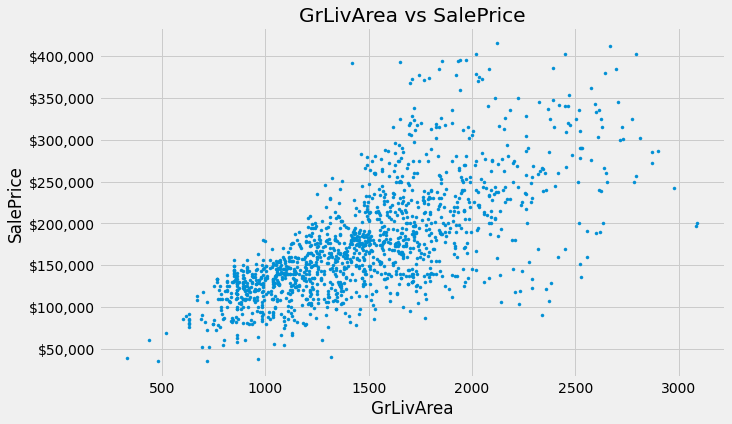

In [15]:
## Create X_clean and y_clean wihtout outliers
X_clean = X[~idx_outliers].copy()
y_clean = y[~idx_outliers].copy()

## Check data with plot_data
plot_data(X_clean,y_clean)

<AxesSubplot:xlabel='SalePrice'>

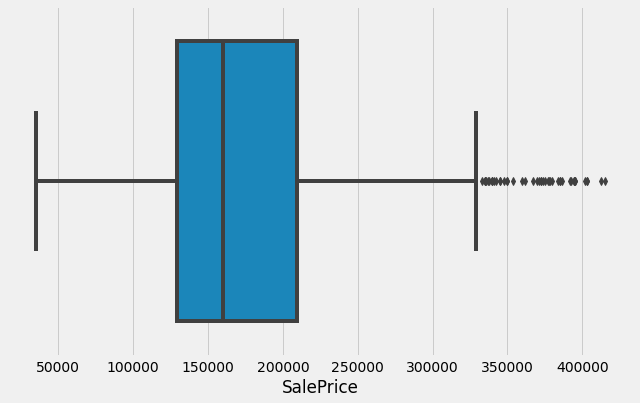

In [16]:
sns.boxplot(y_clean)

In [17]:
## Turn code above for checking normality into a function 
def check_normality(X,y):
    ## Visualize Distributions of X and y and Check Normality
    fig, axes = plt.subplots(ncols=2,figsize=(10,5))

    sns.distplot(X, ax=axes[0], kde=False,bins='auto')
    axes[0].set(xlabel='X')

    sns.distplot(y, ax=axes[1], kde=False,bins='auto',color='orange')
    axes[1].set(xlabel='y')

    print("X Normality: ",stats.normaltest(X))
    print("y Normality: ",stats.normaltest(y))
    return fig, axes


X Normality:  NormaltestResult(statistic=68.09608702296165, pvalue=1.633512955945694e-15)
y Normality:  NormaltestResult(statistic=196.11538475675565, pvalue=2.5946888878777677e-43)


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='X'>, <AxesSubplot:xlabel='y'>], dtype=object))

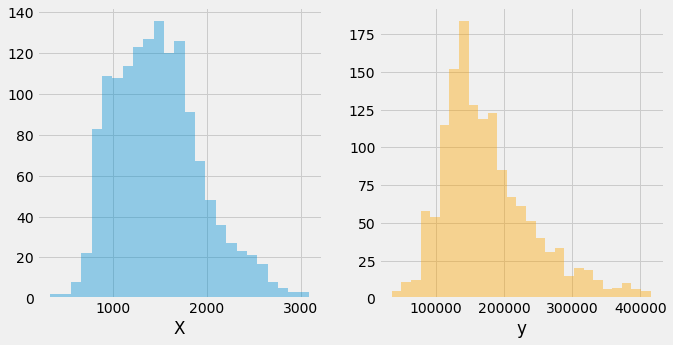

In [18]:
check_normality(X_clean,y_clean)

### OLS with Statsmodels (non-formula version)

In [19]:
from statsmodels.regression.linear_model import OLS
## Add a constant to X to include an intercept in our regression
X_clean = sm.add_constant(X_clean)
display(X_clean)

,const,GrLivArea
0,1.0,1710
1,1.0,1262
2,1.0,1786
3,1.0,1717
4,1.0,2198
...,...,...
1455,1.0,1647
1456,1.0,2073
1457,1.0,2340
1458,1.0,1078


In [20]:
## Make an OLS linear model using original X and y
model = OLS(y_clean,X_clean).fit()
## Check model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1331.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):          1.86e-206
Time:                        13:38:59   Log-Likelihood:                -17432.
No. Observations:                1429   AIC:                         3.487e+04
Df Residuals:                    1427   BIC:                         3.488e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.572e+04   4288.726      5.998      0.000    1.73e+04    3.41e+04
GrLivArea    100.9178      2.766     36.487      0.000      95.492     106.343
==============================================================================
Omnibus:                      132.385   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.546
Skew:                           0.522   Prob(JB):                     6.15e-73
Kurtosis:                       5.121   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

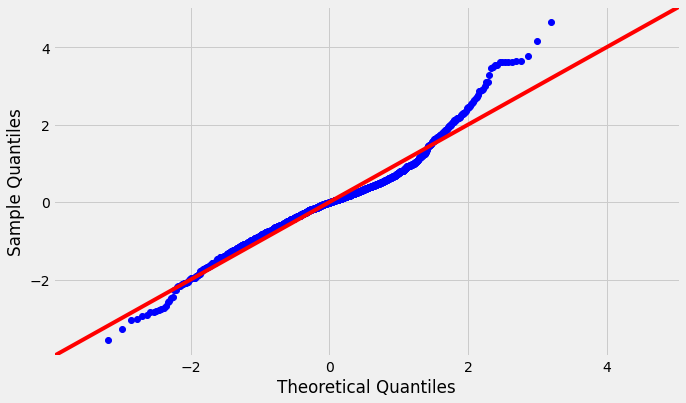

In [21]:
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')

### Not Covered Previously

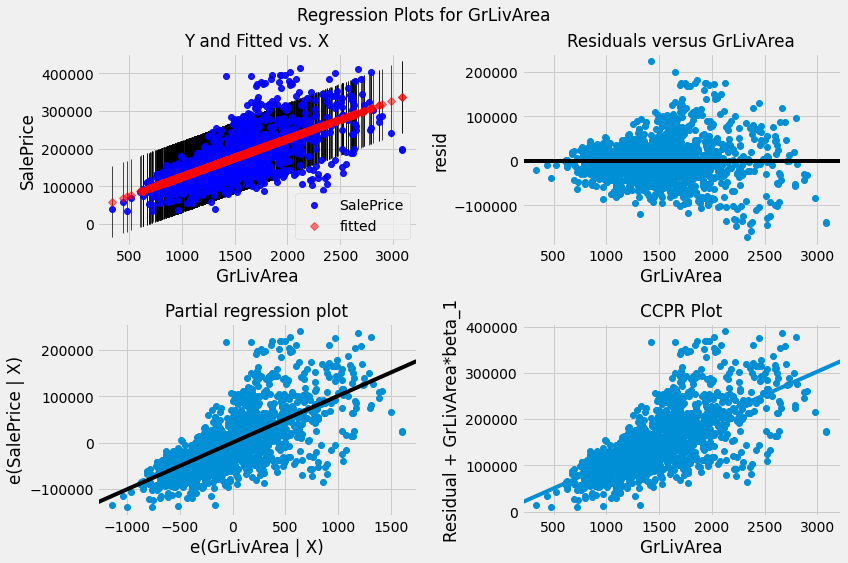

In [22]:
fig = sm.graphics.plot_regress_exog(model, "GrLivArea", fig=plt.figure(figsize=(12,8)))

## Statsmodels OLS - Formula Version

In [23]:
## Make our formula-based Regression
import statsmodels.formula.api as smf
df_clean = df[~idx_outliers].copy()
df_clean

,YrSold,MoSold,Fireplaces,TotRmsAbvGrd,GrLivArea,FullBath,YearRemodAdd,YearBuilt,OverallCond,OverallQual,LotArea,SalePrice
0,2008,2,0,8,1710,2,2003,2003,5,7,8450,208500
1,2007,5,1,6,1262,2,1976,1976,8,6,9600,181500
2,2008,9,1,6,1786,2,2002,2001,5,7,11250,223500
3,2006,2,1,7,1717,1,1970,1915,5,7,9550,140000
4,2008,12,1,9,2198,2,2000,2000,5,8,14260,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2007,8,1,7,1647,2,2000,1999,5,6,7917,175000
1456,2010,2,2,7,2073,2,1988,1978,6,6,13175,210000
1457,2010,5,2,9,2340,2,2006,1941,9,7,9042,266500
1458,2010,4,0,5,1078,1,1996,1950,6,5,9717,142125


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1331.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):          1.86e-206
Time:                        13:39:00   Log-Likelihood:                -17432.
No. Observations:                1429   AIC:                         3.487e+04
Df Residuals:                    1427   BIC:                         3.488e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.572e+04   4288.726      5.998      0.000    1.73e+04    3.41e+04
GrLivArea    100.9178      2.766     36.487      0.000      95.492     106.343
==============================================================================
Omnibus:                      132.385   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.546
Skew:                           0.522   Prob(JB):                     6.15e-73
Kurtosis:                       5.121   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

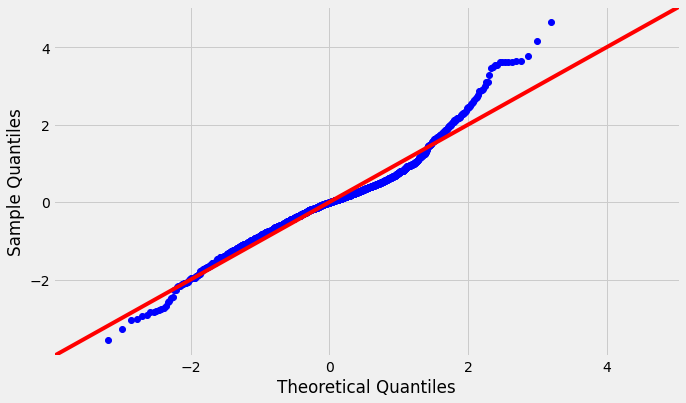

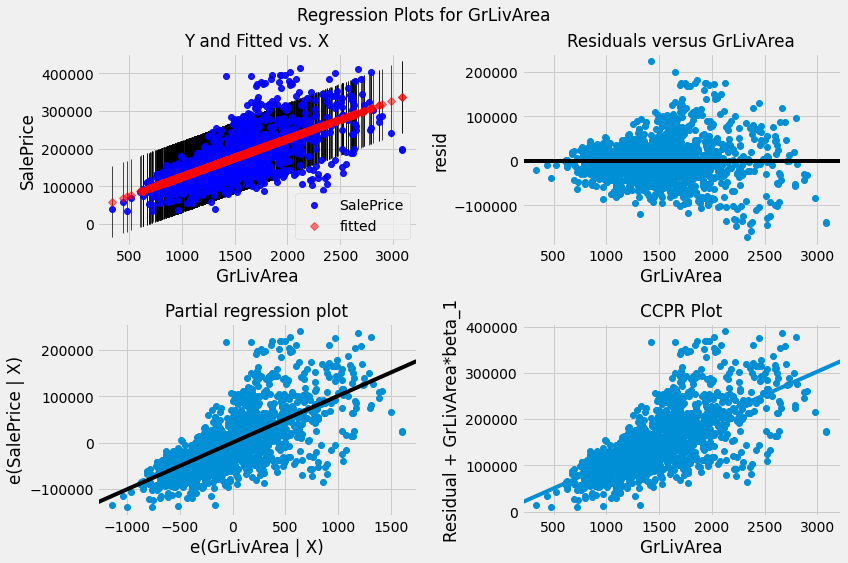

In [24]:
f = "SalePrice~GrLivArea"
model = smf.ols(f,df_clean).fit()
display(model.summary())
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')
fig = sm.graphics.plot_regress_exog(model, "GrLivArea", fig=plt.figure(figsize=(12,8)))

# Multiple Linear Regression

## Single Regression
 $$y=mx+b$$

 $$y = \beta_1 x_1 + \beta_0 $$

<br><br>
## Multiple Predictor/X Variables

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 +\ldots + \beta_n x_n $$

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-multiple-linear-regression-online-ds-ft-100719/master/images/multiple_reg.png" width=400>

#### $\hat Y$ vs $Y$


- Y: Actual value corresponding to a specific X value

- "Y hat" ($\hat Y$): Predicted value predicted fromn a specific X value.


$$ \hat y = \hat\beta_0 + \hat\beta_1 x_1 + \hat\beta_2 x_2 +\ldots + \hat\beta_n x_n $$ 

where $n$ is the number of predictors, $\beta_0$ is the intercept, and $\hat y$ is the so-called "fitted line" or the predicted value associated with the dependent variable.

In [25]:
pd.set_option('display.max_columns',0)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [26]:
# Load in ames dataset
df = fs.datasets.load_ames_train(subset=False)
columns = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice',
           'BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']
df = df[columns].copy()
df.head()

,LotArea,1stFlrSF,GrLivArea,SalePrice,BldgType,KitchenQual,SaleType,MSZoning,Street,Neighborhood
0,8450,856,1710,208500,1Fam,Gd,WD,RL,Pave,CollgCr
1,9600,1262,1262,181500,1Fam,TA,WD,RL,Pave,Veenker
2,11250,920,1786,223500,1Fam,Gd,WD,RL,Pave,CollgCr
3,9550,961,1717,140000,1Fam,Gd,WD,RL,Pave,Crawfor
4,14260,1145,2198,250000,1Fam,Gd,WD,RL,Pave,NoRidge


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LotArea       1460 non-null   int64 
 1   1stFlrSF      1460 non-null   int64 
 2   GrLivArea     1460 non-null   int64 
 3   SalePrice     1460 non-null   int64 
 4   BldgType      1460 non-null   object
 5   KitchenQual   1460 non-null   object
 6   SaleType      1460 non-null   object
 7   MSZoning      1460 non-null   object
 8   Street        1460 non-null   object
 9   Neighborhood  1460 non-null   object
dtypes: int64(4), object(6)
memory usage: 114.2+ KB


In [28]:
df.describe()

,LotArea,1stFlrSF,GrLivArea,SalePrice
count,1460.000,1460.000,1460.000,1460.000
mean,10516.828,1162.627,1515.464,180921.196
std,9981.265,386.588,525.480,79442.503
min,1300.000,334.000,334.000,34900.000
25%,7553.500,882.000,1129.500,129975.000
50%,9478.500,1087.000,1464.000,163000.000
75%,11601.500,1391.250,1776.750,214000.000
max,215245.000,4692.000,5642.000,755000.000


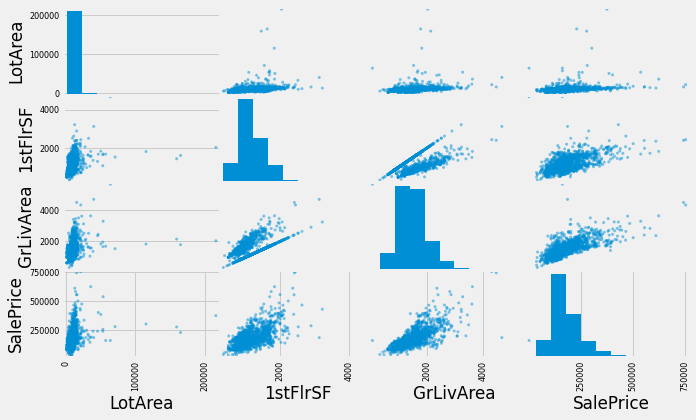

In [29]:
pd.plotting.scatter_matrix(df);

# DEALING WITH CATEGORICAL VARIABLES

- What are categorical variables?
- Understand creating dummy variables for predictors.
- Use pandas and Scikit-Learn to create dumies
- Understand and avoid the "dummy variable trap"

## What are categorical variables?
- Variables that do not represent a continuous/ordinal number. 

## Identifying categorical variables:
What to look for?
1. Column dtype is 'object'
2. Use `df.describe()` -  check for min/max. Are they integers?
3. Use scatterplots & histograms -  look for columns of datapoints

In [30]:
cat_cols = df.select_dtypes('O').columns
cat_cols

Index(['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street',
       'Neighborhood'],
      dtype='object')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LotArea       1460 non-null   int64 
 1   1stFlrSF      1460 non-null   int64 
 2   GrLivArea     1460 non-null   int64 
 3   SalePrice     1460 non-null   int64 
 4   BldgType      1460 non-null   object
 5   KitchenQual   1460 non-null   object
 6   SaleType      1460 non-null   object
 7   MSZoning      1460 non-null   object
 8   Street        1460 non-null   object
 9   Neighborhood  1460 non-null   object
dtypes: int64(4), object(6)
memory usage: 114.2+ KB


In [32]:
num_cols =list(df.select_dtypes('number').columns)
num_cols

['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']

In [33]:
df.isna().sum()

LotArea         0
1stFlrSF        0
GrLivArea       0
SalePrice       0
BldgType        0
KitchenQual     0
SaleType        0
MSZoning        0
Street          0
Neighborhood    0
dtype: int64

In [34]:
## Inspect the Value Counts for Each Str Col
for col in cat_cols:
    display(df[col].value_counts(dropna=False))
    print()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Pave    1454
Grvl       6
Name: Street, dtype: int64

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

## Transforming Categorical Variables

To use categorical variables for regression, they must be transformed.
There are 2 methods to dealing with them:
1. Label Encoding
    - Replace string categories with integer values (0 to n)
    - Can be done with:
        1. Pandas 
        2. Scikit Learn

2. One-hot / dummy encoding
    - Turn each category in a categorical variable into its own variable, that is either a 0 or 1. 0 for rows that do not belong to that sub-category. 1 for rows that belong to the sub-category
    - Can be done with:
        1. Pandas
        2. Scikit Learn


### Label Encoding

In [35]:
## Check the Value Counts for our test column - "BldgType"
df['BldgType'].value_counts(normalize=True)

1Fam     0.836
TwnhsE   0.078
Duplex   0.036
Twnhs    0.029
2fmCon   0.021
Name: BldgType, dtype: float64

#### Via pandas.cat.codes

In [36]:
## Label Encode with .cat.codesd
df['BldgType'] = df['BldgType'].astype('category')
df['BldgType_le'] = df['BldgType'].cat.codes
df['BldgType_le'].value_counts(normalize=True)

0   0.836
4   0.078
2   0.036
3   0.029
1   0.021
Name: BldgType_le, dtype: float64

#### Via Sklearn's LabelEncoder

In [37]:
## Using sklearn LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['BldgType_le_sk'] = encoder.fit_transform(df['BldgType'])
df.head()

,LotArea,1stFlrSF,GrLivArea,SalePrice,BldgType,KitchenQual,SaleType,MSZoning,Street,Neighborhood,BldgType_le,BldgType_le_sk
0,8450,856,1710,208500,1Fam,Gd,WD,RL,Pave,CollgCr,0,0
1,9600,1262,1262,181500,1Fam,TA,WD,RL,Pave,Veenker,0,0
2,11250,920,1786,223500,1Fam,Gd,WD,RL,Pave,CollgCr,0,0
3,9550,961,1717,140000,1Fam,Gd,WD,RL,Pave,Crawfor,0,0
4,14260,1145,2198,250000,1Fam,Gd,WD,RL,Pave,NoRidge,0,0


In [38]:
encoder.inverse_transform(df['BldgType_le_sk'])

array(['1Fam', '1Fam', '1Fam', ..., '1Fam', '1Fam', '1Fam'], dtype=object)

### Dummy Encoding / One-Hot Encoding

#### Via Pandas.get_dummies()

In [39]:
df['BldgType'].unique()

['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']
Categories (5, object): ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']

In [40]:
df_dummies = df.copy()

In [41]:
df_dummies = pd.get_dummies(df,columns=['BldgType'],prefix="ohe")
df_dummies

,LotArea,1stFlrSF,GrLivArea,SalePrice,KitchenQual,SaleType,MSZoning,Street,Neighborhood,BldgType_le,BldgType_le_sk,ohe_1Fam,ohe_2fmCon,ohe_Duplex,ohe_Twnhs,ohe_TwnhsE
0,8450,856,1710,208500,Gd,WD,RL,Pave,CollgCr,0,0,1,0,0,0,0
1,9600,1262,1262,181500,TA,WD,RL,Pave,Veenker,0,0,1,0,0,0,0
2,11250,920,1786,223500,Gd,WD,RL,Pave,CollgCr,0,0,1,0,0,0,0
3,9550,961,1717,140000,Gd,WD,RL,Pave,Crawfor,0,0,1,0,0,0,0
4,14260,1145,2198,250000,Gd,WD,RL,Pave,NoRidge,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,1647,175000,TA,WD,RL,Pave,Gilbert,0,0,1,0,0,0,0
1456,13175,2073,2073,210000,TA,WD,RL,Pave,NWAmes,0,0,1,0,0,0,0
1457,9042,1188,2340,266500,Gd,WD,RL,Pave,Crawfor,0,0,1,0,0,0,0
1458,9717,1078,1078,142125,Gd,WD,RL,Pave,NAmes,0,0,1,0,0,0,0


#### Via Scikit-Learn's LabelBinerizer

In [42]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
ohe_vars = binarizer.fit_transform(df['BldgType'])
pd.DataFrame(ohe_vars,columns=binarizer.classes_)

,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
1455,1,0,0,0,0
1456,1,0,0,0,0
1457,1,0,0,0,0
1458,1,0,0,0,0


### The Dummy Variable Trap


In [43]:
df_dummies = pd.get_dummies(df['BldgType'],drop_first=True)#,prefix="ohe")
df_dummies

,2fmCon,Duplex,Twnhs,TwnhsE
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1455,0,0,0,0
1456,0,0,0,0
1457,0,0,0,0
1458,0,0,0,0


## Testing Out Our Model With Encoded Categorical Data

In [44]:
cat_cols

Index(['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street',
       'Neighborhood'],
      dtype='object')

In [45]:
# df_clean

In [46]:
df_dummies = pd.get_dummies(df,columns=cat_cols,drop_first=True)#,prefix="ohe")
df_dummies

,LotArea,1stFlrSF,GrLivArea,SalePrice,BldgType_le,BldgType_le_sk,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,8450,856,1710,208500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9600,1262,1262,181500,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,11250,920,1786,223500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9550,961,1717,140000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14260,1145,2198,250000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,1647,175000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1456,13175,2073,2073,210000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1457,9042,1188,2340,266500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,9717,1078,1078,142125,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df_dummies.rename({'1stFlrSF':'FirstFlrSF'},axis=1,inplace=True)
df_dummies.columns

Index(['LotArea', 'FirstFlrSF', 'GrLivArea', 'SalePrice', 'BldgType_le',
       'BldgType_le_sk', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'KitchenQual_Fa', 'KitchenQual_Gd',
       'KitchenQual_TA', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Pave', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighbor

In [48]:
features = ' + '.join(df_dummies.drop("SalePrice",axis=1).columns)
features

'LotArea + FirstFlrSF + GrLivArea + BldgType_le + BldgType_le_sk + BldgType_2fmCon + BldgType_Duplex + BldgType_Twnhs + BldgType_TwnhsE + KitchenQual_Fa + KitchenQual_Gd + KitchenQual_TA + SaleType_CWD + SaleType_Con + SaleType_ConLD + SaleType_ConLI + SaleType_ConLw + SaleType_New + SaleType_Oth + SaleType_WD + MSZoning_FV + MSZoning_RH + MSZoning_RL + MSZoning_RM + Street_Pave + Neighborhood_Blueste + Neighborhood_BrDale + Neighborhood_BrkSide + Neighborhood_ClearCr + Neighborhood_CollgCr + Neighborhood_Crawfor + Neighborhood_Edwards + Neighborhood_Gilbert + Neighborhood_IDOTRR + Neighborhood_MeadowV + Neighborhood_Mitchel + Neighborhood_NAmes + Neighborhood_NPkVill + Neighborhood_NWAmes + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Sawyer + Neighborhood_SawyerW + Neighborhood_Somerst + Neighborhood_StoneBr + Neighborhood_Timber + Neighborhood_Veenker'

In [49]:
f = "SalePrice~" + features
f

'SalePrice~LotArea + FirstFlrSF + GrLivArea + BldgType_le + BldgType_le_sk + BldgType_2fmCon + BldgType_Duplex + BldgType_Twnhs + BldgType_TwnhsE + KitchenQual_Fa + KitchenQual_Gd + KitchenQual_TA + SaleType_CWD + SaleType_Con + SaleType_ConLD + SaleType_ConLI + SaleType_ConLw + SaleType_New + SaleType_Oth + SaleType_WD + MSZoning_FV + MSZoning_RH + MSZoning_RL + MSZoning_RM + Street_Pave + Neighborhood_Blueste + Neighborhood_BrDale + Neighborhood_BrkSide + Neighborhood_ClearCr + Neighborhood_CollgCr + Neighborhood_Crawfor + Neighborhood_Edwards + Neighborhood_Gilbert + Neighborhood_IDOTRR + Neighborhood_MeadowV + Neighborhood_Mitchel + Neighborhood_NAmes + Neighborhood_NPkVill + Neighborhood_NWAmes + Neighborhood_NoRidge + Neighborhood_NridgHt + Neighborhood_OldTown + Neighborhood_SWISU + Neighborhood_Sawyer + Neighborhood_SawyerW + Neighborhood_Somerst + Neighborhood_StoneBr + Neighborhood_Timber + Neighborhood_Veenker'

In [50]:
model = smf.ols(f,df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     129.8
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:39:03   Log-Likelihood:                -17324.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1412   BIC:                         3.500e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.171e+05   2.34e+04      4.999      0.000    7.12e+04    1.63e+05
LotArea                  0.4488      0.109      4.103      0.000       0.234       0.663
FirstFlrSF              26.7057      3.448      7.745      0.000      19.942      33.470
GrLivArea               53.2493      2.538     20.982      0.000      48.271      58.228
BldgType_le          -4771.0332    604.062     -7.898      0.000   -5955.988   -3586.078
BldgType_le_sk       -4771.0332    604.062     -7.898      0.000   -5955.988   -3586.078
BldgType_2fmCon      -4382.2763   6676.383     -0.656      0.512   -1.75e+04    8714.420
BldgType_Duplex      -1.049e+04   5066.153     -2.070      0.039   -2.04e+04    -550.519
BldgType_Twnhs       -8784.2270   4976.863     -1.765      0.078   -1.85e+04     978.615
BldgType_TwnhsE       1.174e+04   3365.658      3.487      0.001    5133.010    1.83e+04
KitchenQual_Fa       -8.175e+04   7605.762    -10.749      0.000   -9.67e+04   -6.68e+04
KitchenQual_Gd       -5.172e+04   4355.935    -11.874      0.000   -6.03e+04   -4.32e+04
KitchenQual_TA       -6.873e+04   4819.103    -14.262      0.000   -7.82e+04   -5.93e+04
SaleType_CWD           2.36e+04   1.85e+04      1.278      0.202   -1.26e+04    5.98e+04
SaleType_Con          6.148e+04   2.61e+04      2.356      0.019    1.03e+04    1.13e+05
SaleType_ConLD        1.652e+04   1.33e+04      1.239      0.215   -9628.110    4.27e+04
SaleType_ConLI        1.141e+04   1.68e+04      0.681      0.496   -2.15e+04    4.43e+04
SaleType_ConLw        7098.8153   1.68e+04      0.423      0.672   -2.58e+04       4e+04
SaleType_New          2.727e+04   6767.082      4.030      0.000     1.4e+04    4.05e+04
SaleType_Oth           1.12e+04   2.11e+04      0.532      0.595   -3.01e+04    5.25e+04
SaleType_WD           1.125e+04   5612.242      2.005      0.045     244.131    2.23e+04
MSZoning_FV           2.548e+04   1.65e+04      1.540      0.124   -6975.819    5.79e+04
MSZoning_RH           1.416e+04   1.67e+04      0.849      0.396   -1.86e+04    4.69e+04
MSZoning_RL           2.279e+04   1.39e+04      1.639      0.101   -4489.458    5.01e+04
MSZoning_RM           3.403e+04    1.3e+04      2.612      0.009    8476.227    5.96e+04
Street_Pave          -3805.3061   1.56e+04     -0.244      0.807   -3.44e+04    2.68e+04
Neighborhood_Blueste -6747.7013   2.72e+04     -0.248      0.804   -6.01e+04    4.66e+04
Neighborhood_BrDale  -2.764e+04   1.45e+04     -1.906      0.057   -5.61e+04     804.179
Neighborhood_BrkSide -5.184e+04   1.16e+04     -4.452      0.000   -7.47e+04    -2.9e+04
Neighborhood_ClearCr -2.144e+04   1.21e+04     -1.778      0.076   -4.51e+04    2212.359
Neighborhood_CollgCr -1.208e+04      1e+04     -1.208      0.227   -3.17e+04    7535.598
Neighborhood_Crawfor -9751.3503   1.09e+04     -0.897    

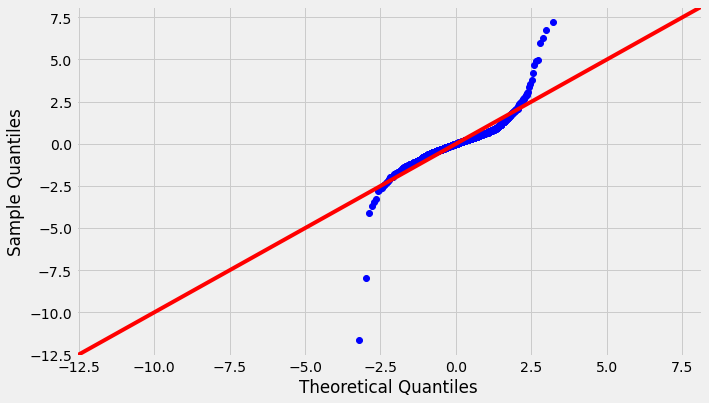

In [51]:
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')

# fig = sm.graphics.plot_regress_exog(model, "", fig=plt.figure(figsize=(12,8)))

In [52]:
[col for col in df.columns if '_le' in col]

['BldgType_le', 'BldgType_le_sk']

In [53]:
repl_dict = {'1stFlrSF':'FirstFlrSF',
                       '1Fam':'OneFam',
                       '2fmCon':'TwoFamCon'}
df.rename(repl_dict,axis=1, inplace=True)
df['BldgType'].replace({'1stFlrSF':'FirstFlrSF',
                       '1Fam':'OneFam',
                       '2fmCon':'TwoFamCon'},inplace=True)
df['BldgType'].value_counts()

OneFam       1220
TwnhsE        114
Duplex         52
Twnhs          43
TwoFamCon      31
Name: BldgType, dtype: int64

In [54]:
df

,LotArea,FirstFlrSF,GrLivArea,SalePrice,BldgType,KitchenQual,SaleType,MSZoning,Street,Neighborhood,BldgType_le,BldgType_le_sk
0,8450,856,1710,208500,OneFam,Gd,WD,RL,Pave,CollgCr,0,0
1,9600,1262,1262,181500,OneFam,TA,WD,RL,Pave,Veenker,0,0
2,11250,920,1786,223500,OneFam,Gd,WD,RL,Pave,CollgCr,0,0
3,9550,961,1717,140000,OneFam,Gd,WD,RL,Pave,Crawfor,0,0
4,14260,1145,2198,250000,OneFam,Gd,WD,RL,Pave,NoRidge,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,1647,175000,OneFam,TA,WD,RL,Pave,Gilbert,0,0
1456,13175,2073,2073,210000,OneFam,TA,WD,RL,Pave,NWAmes,0,0
1457,9042,1188,2340,266500,OneFam,Gd,WD,RL,Pave,Crawfor,0,0
1458,9717,1078,1078,142125,OneFam,Gd,WD,RL,Pave,NAmes,0,0


In [55]:
df

,LotArea,FirstFlrSF,GrLivArea,SalePrice,BldgType,KitchenQual,SaleType,MSZoning,Street,Neighborhood,BldgType_le,BldgType_le_sk
0,8450,856,1710,208500,OneFam,Gd,WD,RL,Pave,CollgCr,0,0
1,9600,1262,1262,181500,OneFam,TA,WD,RL,Pave,Veenker,0,0
2,11250,920,1786,223500,OneFam,Gd,WD,RL,Pave,CollgCr,0,0
3,9550,961,1717,140000,OneFam,Gd,WD,RL,Pave,Crawfor,0,0
4,14260,1145,2198,250000,OneFam,Gd,WD,RL,Pave,NoRidge,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,1647,175000,OneFam,TA,WD,RL,Pave,Gilbert,0,0
1456,13175,2073,2073,210000,OneFam,TA,WD,RL,Pave,NWAmes,0,0
1457,9042,1188,2340,266500,OneFam,Gd,WD,RL,Pave,Crawfor,0,0
1458,9717,1078,1078,142125,OneFam,Gd,WD,RL,Pave,NAmes,0,0


In [56]:
df.drop(columns=[col for col in df.columns if '_le' in col],inplace=True,axis=1)

In [57]:
df.head()

,LotArea,FirstFlrSF,GrLivArea,SalePrice,BldgType,KitchenQual,SaleType,MSZoning,Street,Neighborhood
0,8450,856,1710,208500,OneFam,Gd,WD,RL,Pave,CollgCr
1,9600,1262,1262,181500,OneFam,TA,WD,RL,Pave,Veenker
2,11250,920,1786,223500,OneFam,Gd,WD,RL,Pave,CollgCr
3,9550,961,1717,140000,OneFam,Gd,WD,RL,Pave,Crawfor
4,14260,1145,2198,250000,OneFam,Gd,WD,RL,Pave,NoRidge


In [58]:
cat_cols

Index(['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street',
       'Neighborhood'],
      dtype='object')

In [59]:
"Licks ~ C(Group) + C(Phase)"

'Licks ~ C(Group) + C(Phase)'

In [60]:
cat_features = '+'.join([f"C({col})" for col in cat_cols])
cat_features

'C(BldgType)+C(KitchenQual)+C(SaleType)+C(MSZoning)+C(Street)+C(Neighborhood)'

In [61]:
num_cols = list(df.select_dtypes('number').columns)
num_cols.remove('SalePrice')
num_cols

['LotArea', 'FirstFlrSF', 'GrLivArea']

In [62]:
## EITHER USE FORMULA OLS or normal OLS 
features = '+'.join(num_cols) + '+' + cat_features
features =  features.replace('SalePrice','')
features

'LotArea+FirstFlrSF+GrLivArea+C(BldgType)+C(KitchenQual)+C(SaleType)+C(MSZoning)+C(Street)+C(Neighborhood)'

In [63]:
f = "SalePrice ~" + features
f

'SalePrice ~LotArea+FirstFlrSF+GrLivArea+C(BldgType)+C(KitchenQual)+C(SaleType)+C(MSZoning)+C(Street)+C(Neighborhood)'

In [64]:
## Non-Formula OLS
model =  smf.ols(f,df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     129.8
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:39:03   Log-Likelihood:                -17324.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1412   BIC:                         3.500e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   8.755e+04   2.38e+04      3.676      0.000    4.08e+04    1.34e+05
C(BldgType)[T.OneFam]       2.957e+04   5264.990      5.617      0.000    1.92e+04    3.99e+04
C(BldgType)[T.Twnhs]       -7837.7776   9036.983     -0.867      0.386   -2.56e+04    9889.579
C(BldgType)[T.TwnhsE]       3139.6220   7074.089      0.444      0.657   -1.07e+04     1.7e+04
C(BldgType)[T.TwoFamCon]    1.565e+04   8387.455      1.866      0.062    -804.907    3.21e+04
C(KitchenQual)[T.Fa]       -8.175e+04   7605.762    -10.749      0.000   -9.67e+04   -6.68e+04
C(KitchenQual)[T.Gd]       -5.172e+04   4355.935    -11.874      0.000   -6.03e+04   -4.32e+04
C(KitchenQual)[T.TA]       -6.873e+04   4819.103    -14.262      0.000   -7.82e+04   -5.93e+04
C(SaleType)[T.CWD]           2.36e+04   1.85e+04      1.278      0.202   -1.26e+04    5.98e+04
C(SaleType)[T.Con]          6.148e+04   2.61e+04      2.356      0.019    1.03e+04    1.13e+05
C(SaleType)[T.ConLD]        1.652e+04   1.33e+04      1.239      0.215   -9628.110    4.27e+04
C(SaleType)[T.ConLI]        1.141e+04   1.68e+04      0.681      0.496   -2.15e+04    4.43e+04
C(SaleType)[T.ConLw]        7098.8153   1.68e+04      0.423      0.672   -2.58e+04       4e+04
C(SaleType)[T.New]          2.727e+04   6767.082      4.030      0.000     1.4e+04    4.05e+04
C(SaleType)[T.Oth]           1.12e+04   2.11e+04      0.532      0.595   -3.01e+04    5.25e+04
C(SaleType)[T.WD]           1.125e+04   5612.242      2.005      0.045     244.131    2.23e+04
C(MSZoning)[T.FV]           2.548e+04   1.65e+04      1.540      0.124   -6975.819    5.79e+04
C(MSZoning)[T.RH]           1.416e+04   1.67e+04      0.849      0.396   -1.86e+04    4.69e+04
C(MSZoning)[T.RL]           2.279e+04   1.39e+04      1.639      0.101   -4489.458    5.01e+04
C(MSZoning)[T.RM]           3.403e+04    1.3e+04      2.612      0.009    8476.227    5.96e+04
C(Street)[T.Pave]          -3805.3061   1.56e+04     -0.244      0.807   -3.44e+04    2.68e+04
C(Neighborhood)[T.Blueste] -6747.7013   2.72e+04     -0.248      0.804   -6.01e+04    4.66e+04
C(Neighborhood)[T.BrDale]  -2.764e+04   1.45e+04     -1.906      0.057   -5.61e+04     804.179
C(Neighborhood)[T.BrkSide] -5.184e+04   1.16e+04     -4.452      0.000   -7.47e+04    -2.9e+04
C(Neighborhood)[T.ClearCr] -2.144e+04   1.21e+04     -1.778      0.076   -4.51e+04    2212.359
C(Neighborhood)[T.CollgCr] -1.208e+04      1e+04     -1.208      0.227   -3.17e+04    7535.598
C(Neighborhood)[T.Crawfor] -9751.3503   1.09e+04     -0.897      0.370   -3.11e+04    1.16e+04
C(Neighborhood)[T.Edwards] -5.642e+04   1.04e+04     -5.409      0.000   -7.69e+04    -3.6e+04
C(Neighborhood)[T.Gilbert] -1.605e+04   1.06e+04     -1.518      0.129   -3.68e+04    4689.230
C(Neighborhood)[T.IDOTRR]  -6.685e+04   1.3

In [65]:
## View Model Summary
model

# Multicollinearity
- An additional concern to check for.
- Rule of thumb is if correlation between vars is >0.70 is too high


In [66]:
## Get the correlation matrix for our model_df
corr = df.corr()
mask = np.zeros_like(corr)
mask

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [67]:
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

<AxesSubplot:>

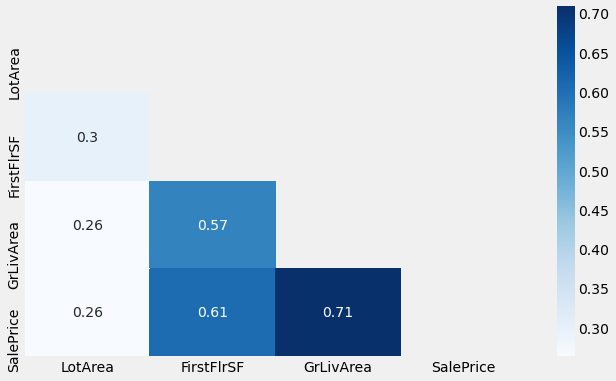

In [68]:
sns.heatmap(corr, annot=True,cmap="Blues",mask=mask)

In [69]:
# Checking Visually 

def multiplot():

    return fig, ax


# 